## CS69000DPL - Deep Learning 
## Spring 2020
### Instructor and Copyright: <a href="https://www.cs.purdue.edu/homes/ribeirob/">Bruno Ribeiro</a>
----

## Homework 1

## Due date: 1/28 (Tuesday)  6:00am

##  Homework: MLP Classifier

### Q0 (REQUIRED): Mark the appropriate answers with an X 
**(0pts correct answer, -1,000pts incorrect answer: (0,-1,000) pts):** A correct answer to the following questions is worth 0pts. An incorrect answer is worth -1,000pts, which carries over to other homeworks and exams, and can result in an F grade in the course.

(1) Student interaction with other students / individuals:
- (a) I have copied part of my homework from another student or another person (plagiarism).
- (b) Yes, I discussed the homework with another person but came up with my own answers. Their name(s) is (are)
- (c) No, I did not discuss the homework with anyone


(2) On using online resources:
- (a) I have copied one of my answers directly from a website (plagiarism).
- (b) I have used online resources to help me answer this question, but I came up with my own answers (you are allowed to use online resources as long as the answer is your own). Here is a list of the websites I have used in this homework:
- (c) I have not used any online resources except the ones provided in the course website.

### Q1: Task (10 pts)

In this homework you will have  to modify this Jupyter notebook to
1. Add one extra hidden layer 
2. Change the ReLU activations to sigmoid activations at all hidden layers
3. Not change anything else (i.e., keep the softmax activation, etc.)
4. Change the textual description of the neural network, its foward and backward passes

**Details:**
- You should change the textual mathematical description of the backpropagation procedure to accomodate the change from ReLU to sigmoid and the addition of an extra hidden layer.  Finding where you need to change the description is considered part of the homework.
- The extra hidden layer should have the same number of neurons.
- You must change the ```forward``` and ```backward``` functions in the code to accomodate the change from ReLU to sigmoid and the addition of one hidden layer
- Run the python notebook and submit the resulting .ipynb file with your modifications and the resulting test accuracy and visual test evaluation
- Make sure you have made all changes and saved them before submitting your homework
- Make sure you show your derivations to get partial credit. 
- Comment your changes in the code to help us give partial credit.


### Code and description

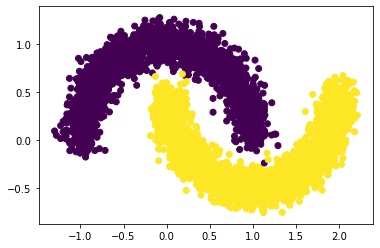

In [1]:
%matplotlib inline
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import pylab
import numpy as np

X, y = make_moons(n_samples=5000, random_state=42, noise=0.1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,test_size=0.3)

pylab.scatter(X[:,0], X[:,1], c=y)
pylab.show()

### Create the Neural Network Weights and Initialize Them

We first define:
* the input layer (two coordinates)
* number of hidden layers (we will use one)
* the number of output neurons (number of classes, two in our case) 


In [2]:
# There are only two features in the data X[:,0] and X[:,1]
n_feature = 2
# There are only two classes: 0 (purple) and 1 (yellow)
n_class = 2

def init_weights(n_hidden=100):
    # Initialize weights with Standard Normal random variables
    model = dict(
        W1=np.random.randn(n_feature + 1, n_hidden),
        W2=np.random.randn(n_hidden + 1, n_class)
    )

    return model

### Define the nonlinear activation function (will be used in the last layer)

We will use the softmax function. 

$$
\text{softmax}(x_i) = \frac{\exp(x_i)}{\sum_j \exp(x_j)}
$$

If there are only two classes, the softmax is equivalent to the logistic function (do the math to convince yourself).

#### Python + Numpy tricks
Numpy is *very* handy. If we give a vector ${\bf z}$, np.exp(${\bf z}$) returns a vector with all elements of $z$ exponentiated.

If ${\bf z}$ is a vector, ${\bf z}$.sum() returns the sum of the elements in ${\bf z}$.

In [3]:
# Defines the softmax function. For two classes, this is equivalent to the logistic regression
def softmax(x):
    return np.exp(x) / np.exp(x).sum()

### Define the forward pass

Here, we define how the neural network get an input $x$ and use the model paramters (weights) ${\bf W}^{(1)}$ and ${\bf W}^{(2)}$ and biases ${\bf b}^{(1)}$ and ${\bf b}^{(2)}$ to predict the class labels of the input

#### Hidden layer activation

From the input vector $x$ to the hidden layer neurons $h$, we need to get the intermediate value
$$
{\bf z}^{(1)} = {\bf x}^T {\bf W}^{(1)} + {\bf b}^{(1)}
$$
and pass it through an activation function.

Our activation function is the ReLU:
$$
\text{ReLU}(z) = \begin{cases} z & ,\text{if }z \geq 0 \\
0 & ,\text{if }z < 0
\end{cases}
$$
Thus, $${\bf h} = \text{ReLU}({\bf z}^{(1)}).$$

Once we get the hidden layer values ${\bf h}$, we do
$$
{\bf z}^{(2)} = {\bf h}^T {\bf W}^{(2)} + {\bf b}^{(2)}
$$
and pass it through the activation of the last layer
$$
\hat{\bf y} = \text{softmax}({\bf z}^{(2)}).
$$

In [4]:
# For a single example $x$
def forward(x, model):
    x = np.append(x, 1)
    
    # Input times first layer matrix 
    z_1 = x @ model['W1']

    # ReLU activation goes to hidden layer
    h = z_1
    h[z_1 < 0] = 0

    # Hidden layer values to output
    h = np.append(h, 1)
    hat_y = softmax(h @ model['W2'])

    return h, hat_y

### Define backpropagation

Now, we need to backpropagate the derivatives of each example

The backpropagation function gets:
* all input data $\{{\bf x}(i)\}_i$
* corresponding hidden values of *all* training examples: $\{{\bf h}(i)\}_i$
* errors of each output neuron for *all* training examples: $\{{\bf y}(i) - \hat{\bf y}(i)\}_i$ (this is a subtraction of two vectors)

Our score function of training example $i$ will be, which is the log likelihood of a one-hot enconding vector of the classes,
$$
L(i) = \sum_j y_j(i) \log \hat{y}_j(i) ,
$$
where $y_i(j)$ is the element $j$ of the vector representing the one-hot enconding of the class of training example $i$ and $\hat{y}_j(i)$ is the output of the $j$-th output neuron for training example $i$,
$$
\hat{y}_j(i) = \frac{\exp(z^{(2)}_j)}{\sum_m \exp(z^{(2)}_m)}.
$$

The derivative of the loss with respect to ${\bf z}^{(2)}$ will be a vector (that we will represent using the variables without the index $j$)
$$
\frac{\partial L(i)}{\partial {\bf z}^{(2)}} = (y_1(i) - \hat{y}_1(i),\ldots,y_\text{n_class}(i) - \hat{y}_\text{n_class}(i)) = {\bf y}(i) - \hat{{\bf y}}(i).
$$
**Note that we can get this derivative directly from the relative error `errs`.**

#### Other derivatives


It will compute the following derivatives for each training example:
* The derivative of the last layer parameters are
$$
\frac{\partial L(i)}{\partial {\bf W}^{(2)}} = \frac{\partial {\bf z}^{(2)}(i)}{\partial {\bf W}^{(2)}}  \frac{\partial L(i)}{\partial {\bf z}^{(2)}} = {\bf h}(i)^T  ({\bf y}(i) - \hat{\bf y}(i))
$$
and
$$
\frac{\partial L(i)}{\partial {\bf b}^{(2)}} = \frac{\partial {\bf z}^{(2)}(i)}{\partial {\bf b}^{(2)}}  \frac{\partial L(i)}{\partial {\bf z}^{(2)}} =  ({\bf y}(i) - \hat{\bf y}(i)),
$$
as 
$$
\frac{\partial {\bf z}^{(2)}(i)}{\partial {\bf b}^{(2)}} = 1.
$$

* The derivatives with respect to the hidden values of the previous layer are
$$
\frac{\partial L(i)}{\partial {\bf h}} = \frac{\partial {\bf z}^{(2)}(i)}{\partial {\bf h}}  \frac{\partial L(i)}{\partial {\bf z}^{(2)}} =  {\bf W}^{(2)} ({\bf y}(i) - \hat{\bf y}(i))
$$

We then backpropagate $\partial L(i)/\partial {\bf h} $ to the previous layer. This will be needed in the final derivative
the final derivatives are
$$
\frac{\partial L(i)}{\partial {\bf W}^{(1)}} = \frac{\partial {\bf z}^{(1)}(i)}{\partial {\bf W}^{(1)}} \frac{\partial {\bf h}(i)}{\partial {\bf z}^{(1)}} \frac{\partial L(i)}{\partial {\bf h}},
$$ 
and
$$
\frac{\partial L(i)}{\partial {\bf b}^{(1)}} = \frac{\partial {\bf z}^{(1)}(i)}{\partial {\bf b}^{(1)}} \frac{\partial {\bf h}(i)}{\partial {\bf z}^{(1)}} \frac{\partial L(i)}{\partial {\bf h}},
$$ 
where 
$$
\frac{\partial {\bf z}^{(1)}(i)}{\partial {\bf W}^{(1)}} = {\bf x}(i)^T,
$$
and
$$
\frac{\partial {\bf z}^{(1)}(i)}{\partial {\bf b}^{(1)}} = 1,
$$
and the derivative of the ReLU
$$
\frac{\partial {\bf h}(i)}{\partial {\bf z}^{(1)}} = \begin{cases} 1 &, \text{if }{\bf z}^{(1)}(i) > 0\\
                                                   0 & \text{otherwise}. \end{cases}.
$$


The final output are the derivatives of the parameters.

<span style="color:blue"> In the above, we have described the backpropagation algorithm *per training example*. 
The following python code will, as described earlier, give all examples as inputs. Thus, the input is a matrix whose rows are the vectors of each training example.</span>

This function outputs 
$$
{\bf \text{d}W}^{(1)} = \frac{1}{N} \sum_{i=1}^N \frac{\partial L(i)}{\partial {\bf W}^{(1)}},
$$ 
$$
{\bf \text{d}b}^{(1)} = \frac{1}{N} \sum_{i=1}^N \frac{\partial L(i)}{\partial {\bf b}^{(1)}},
$$ 
$$
{\bf \text{d}W}^{(2)} =  \frac{1}{N} \sum_{i=1}^N \frac{\partial L(i)}{\partial {\bf W}^{(2)}},
$$
and
$$
{\bf \text{d}b}^{(2)} =  \frac{1}{N} \sum_{i=1}^N \frac{\partial L(i)}{\partial {\bf b}^{(2)}}.
$$

In [33]:
def backward(model, xs, hs, errs):
    #print (xs.shape)
    #print (hs.shape)
    #print (errs.shape)
    
    """xs, hs, errs contain all information (input, hidden state, error) of all data in the minibatch"""
    # errs is the gradients of output layer for the minibatch
    dW2 = (hs.T @ errs)/xs.shape[0]

    # Get gradient of hidden layer
    dh = errs @ model['W2'].T
    dh[hs <= 0] = 0
    
    # The bias "neuron" is the constant 1, we don't need to backpropagate its gradient
    # since it has no inputs, so we just remove its column from the gradient
    dh = dh[:, :-1]

    # Add the 1 to the data, to compute the gradient of W1
    xs = np.hstack([xs, np.ones((xs.shape[0], 1))])

    dW1 = (xs.T @ dh)/xs.shape[0]

    return dict(W1=dW1, W2=dW2)

### Perform the forward and backward procedures to get gradients

For each input example $i$ in the training data, perform a forward pass and:
* store all the hidden units of all the hidden layers associated with example $i$ (we only have to store one vector of hidden values)
* store the gradient of the error of example $i$ with respect to the prediction

Once we have store all hidden layer values and all the derivatives of all examples, 
we will do the backard pass and return the derivatives of the error with respect to the paramters ${\bf W}^{(1)}$, ${\bf b}^{(1)}$, ${\bf W}^{(2)}$, and ${\bf b}^{(2)}$.

In [34]:
def get_gradient(model, X_train, y_train):
    xs, hs, errs = [], [], []

    for x, cls_idx in zip(X_train, y_train):
        h, y_pred = forward(x, model)

        # Create one-hot coding of true label
        y_true = np.zeros(n_class)
        y_true[int(cls_idx)] = 1.

        # Compute the gradient of output layer
        err = y_true - y_pred

        # Accumulate the informations of the examples
        # x: input
        # h: hidden state
        # err: gradient of output layer
        xs.append(x)
        hs.append(h)
        errs.append(err)

    # Backprop using the informations we get from the current minibatch
    return backward(model, np.array(xs), np.array(hs), np.array(errs))

### Define one gradient ascent step

We now perform a single gradient ascent step.

Get the gradients and perform the following updates for $N$ training examples:
$$
{\bf W}^{(1)} ={\bf W}^{(1)} + \epsilon \frac{1}{N} \sum_{i=1}^N \frac{\partial L(i)}{\partial {\bf W}^{(1)}},
$$
$$
{\bf b}^{(1)} ={\bf b}^{(1)} + \epsilon \frac{1}{N} \sum_{i=1}^N \frac{\partial L(i)}{\partial {\bf b}^{(1)}},
$$
$$
{\bf W}^{(2)} ={\bf W}^{(2)} + \epsilon \frac{1}{N} \sum_{i=1}^N \frac{\partial L(i)}{\partial {\bf W}^{(2)}},
$$
and
$$
{\bf b}^{(2)} ={\bf b}^{(2)} + \epsilon \frac{1}{N} \sum_{i=1}^N \frac{\partial L(i)}{\partial {\bf b}^{(2)}},
$$
where $\epsilon = 10^{-1}$ in our example.

In [44]:
def gradient_step(model, X_train, y_train, learning_rate=1e-1):
    grad = get_gradient(model, X_train, y_train)
    model = model.copy()
    #print ("grad", grad['W1'].shape, grad['W2'].shape) #grad (3, 100) (101, 2)
    
    #print ("model", model['W1'].shape, model['W2'].shape) #model  (3, 100) (101, 2)
    # Update every parameters in our networks (W1 and W2) using their gradients
    for layer in grad:
        # Learning rate: 1e-1
        model[layer] += learning_rate * grad[layer]

    return model

### Repeat gradient ascent a few more times...

In [45]:
def gradient_ascent(model, X_train, y_train, no_iter=100):
    for iter in range(no_iter):
        print('Iteration {}'.format(iter))

        model = gradient_step(model, X_train, y_train)

    return model

### Train the model

We now train the model.

In [46]:
no_iter = 100

# Reset model
model = init_weights()

# Train the model
model = gradient_ascent(model, X_train, y_train, no_iter=no_iter)


Iteration 0
Iteration 1
Iteration 2
Iteration 3
Iteration 4
Iteration 5
Iteration 6
Iteration 7
Iteration 8
Iteration 9
Iteration 10
Iteration 11
Iteration 12
Iteration 13
Iteration 14
Iteration 15
Iteration 16
Iteration 17
Iteration 18
Iteration 19
Iteration 20
Iteration 21
Iteration 22
Iteration 23
Iteration 24
Iteration 25
Iteration 26
Iteration 27
Iteration 28
Iteration 29
Iteration 30
Iteration 31
Iteration 32
Iteration 33
Iteration 34
Iteration 35
Iteration 36
Iteration 37
Iteration 38
Iteration 39
Iteration 40
Iteration 41
Iteration 42
Iteration 43
Iteration 44
Iteration 45
Iteration 46
Iteration 47
Iteration 48
Iteration 49
Iteration 50
Iteration 51
Iteration 52
Iteration 53
Iteration 54
Iteration 55
Iteration 56
Iteration 57
Iteration 58
Iteration 59
Iteration 60
Iteration 61
Iteration 62
Iteration 63
Iteration 64
Iteration 65
Iteration 66
Iteration 67
Iteration 68
Iteration 69
Iteration 70
Iteration 71
Iteration 72
Iteration 73
Iteration 74
Iteration 75
Iteration 76
Iteration

#### Let's evaluate the model on test data
Note that the output has two neurons for the two classes. Our prediction will chose the class corresponding to the 
largest output neuron value.

In [47]:
y_pred = np.zeros_like(y_test)

accuracy = 0

for i, x in enumerate(X_test):
    # Predict the distribution of label
    _, prob = forward(x, model)
    # Get label by picking the most probable one
    y = np.argmax(prob)
    y_pred[i] = y

# Accuracy of predictions with the true labels and take the percentage
# Because our dataset is balanced, measuring just the accuracy is OK
accuracy = (y_pred == y_test).sum() / y_test.size
print('Test accuracy after {} gradient steps: {}'.format(no_iter,accuracy))

Test accuracy after 100 gradient steps: 0.986


#### Let's visually evaluate the model on the test data


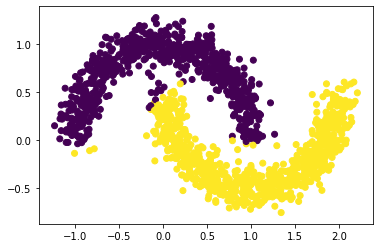

In [48]:
pylab.scatter(X_test[:,0], X_test[:,1], c=y_pred)
pylab.show()